# Generating Architectures

In [1]:
pattern = """architecture:
  version: 0.4
  nodes:
  - !Container
    name: System
    attributes:
      technology: "40nm"
      global_cycle_seconds: 1e-9

  - !Component
    name: MainMemory
    class: DRAM
    attributes:
      width: 256
      datawidth: 8

  - !Component
    name: GlobalBuffer
    class: SRAM
    attributes:
      depth: {_globalBufferSize}
      width: 64
      datawidth: 8

  - !Container
    name: PE
    spatial: {{meshX: {_sizeX}, meshY: {_sizeY}}}

  - !Component
    name: RegisterFile
    class: regfile
    attributes:
      depth: {_regFileSize}
      width: 8
      datawidth: 8

  - !Component
    name: MACC
    class: intmac
    attributes:
      datawidth: 8"""

architectureNamePattern = "customArchitectures/{_sizeX}_{_sizeY}_{_globalBufferSize}_{_regFileSize}.yaml"

In [27]:
pattern = """architecture:
  # ============================================================
  # Architecture Description
  # ============================================================
  version: 0.4
  nodes: # Top-level is hierarchical
  - !Container # Top-level system
    name: system
    attributes:
      technology: "32nm"
      global_cycle_seconds: 1e-9
  
  - !Component # DRAM main memory
    name: DRAM
    class: DRAM
    attributes:
      type: "LPDDR4"
      width: 64
      datawidth: 8

  - !Container # Eyeriss accelerator
    name: eyeriss

  - !Component # Global buffer for inputs & outputs
    name: shared_glb
    class: smartbuffer_SRAM
    attributes:
      depth: {_globalBufferSize}
      width: 64
      n_banks: 32
      datawidth: 8
      read_bandwidth: 16
      write_bandwidth: 16
    constraints:
      dataspace: {{keep: [Inputs, Outputs], bypass: [Weights]}}

  - !Container # Each column of PEs produces a different psum row
    name: PE_column
    spatial: {{meshX: {_sizeX}}}
    constraints:
      spatial:
        permutation: [N, C, P, R, S, Q, M]
        factors: [N=1, C=1, P=1, R=1, S=1]
        split: 7

  - !Container # Each PE in the column receives a different filter row
    name: PE
    spatial: {{meshY: {_sizeY}}}
    constraints:
      spatial:
        split: 4
        permutation: [N, P, Q, R, S, C, M]
        factors: [N=1, P=1, Q=1, R=1]

  - !Parallel # Input/Output/Weight scratchpads in parallel
    nodes:
    - !Component # Input scratchpad
      name: ifmap_spad
      class: smartbuffer_RF
      attributes:
        depth: {_inputBufferSize}
        width: 16
        datawidth: 8
        read_bandwidth: 2
        write_bandwidth: 2
      constraints:
        dataspace: {{keep: [Inputs]}}
        temporal:
          permutation: [N, M, C, P, Q, R, S]
          factors: [N=1, M=1, C=1, P=1, Q=1, R=1, S=1]

    - !Component # Weight scratchpad
      name: weights_spad
      class: smartbuffer_RF
      attributes:
        depth: {_weightBufferSize}
        width: 16
        datawidth: 8
        read_bandwidth: 2
        write_bandwidth: 2
      constraints:
        dataspace: {{keep: [Weights]}}
        temporal:
          permutation: [N, M, P, Q, S, C, R]
          factors: [N=1, M=1, P=1, Q=1, S=1]

    - !Component # Output scratchpad
      name: psum_spad
      class: smartbuffer_RF
      attributes:
        depth: {_outputBufferSize}
        width: 16
        update_fifo_depth: 2
        datawidth: 16
        read_bandwidth: 2
        write_bandwidth: 2
      constraints:
        dataspace: {{keep: [Outputs]}}
        temporal:
          permutation: [N, C, P, Q, R, S, M] 
          factors: [N=1, C=1, R=1, S=1, P=1, Q=1]

  - !Component # MAC unit
    name: mac
    class: intmac
    attributes:
      multiplier_width: 8
      adder_width: 16"""

architectureNamePattern = "customArchitectures/{_sizeX}_{_sizeY}_{_globalBufferSize}_{_bufferSize}.yaml"

In [28]:
peSizes = [(4,64), (8,32), (16,16), (32,8), (64,4)]
globalBufferSizes = [1024, 2048, 4096, 8192, 16384, 32768]
bufferSizes = [2,4,8,16,24,32,64,128,192,256]

In [29]:
for (sizeX, sizeY) in peSizes:
    for globalBufferSize in globalBufferSizes:
        for bufferSize in bufferSizes:
            architecture = pattern.format(_sizeX = sizeX,
                                            _sizeY = sizeY,
                                            _globalBufferSize = globalBufferSize,
                                            _inputBufferSize = bufferSize,
                                            _weightBufferSize = bufferSize,
                                            _outputBufferSize = bufferSize)
            fileName = architectureNamePattern.format(_sizeX = sizeX,
                                            _sizeY = sizeY,
                                            _globalBufferSize = globalBufferSize,
                                            _bufferSize = bufferSize)
            f = open(fileName, "w")
            f.write(architecture)
            f.close()

# Calculating Results

In [31]:
import os
import timeloopfe.v4 as tl
from joblib import Parallel, delayed
from tqdm.auto import tqdm
#vgg16
#layers = ["00", "02", "04", "07", "10"]
#resnet18
#layers = ["00", "01", "06", "11", "16"]
#all
layers = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
#area
#layers = ["00"]

THIS_SCRIPT_DIR = os.getcwd()

print(THIS_SCRIPT_DIR)

architectureDirectory = os.path.join(THIS_SCRIPT_DIR, "customArchitectures5/")
outputDirectory = os.path.join(THIS_SCRIPT_DIR, "outputs5/")

#architectureDirectory = os.path.join(THIS_SCRIPT_DIR, "customArchitectures3Input/")

def run_mapper_with_spec(file, layer):
    filename = file[:-5]
    if not os.path.isdir(os.path.join(THIS_SCRIPT_DIR, outputDirectory + filename + "/" + layer)):
        spec = tl.Specification.from_yaml_files(
                os.path.join(architectureDirectory, file),
                os.path.join("components/*.yaml"),
                os.path.join(THIS_SCRIPT_DIR, "example_designs/layer_shapes/resnet18/" + layer + ".yaml"),
                os.path.join(THIS_SCRIPT_DIR, "mapper.yaml"),
            )
        tl.call_mapper(spec, output_dir=os.path.join(THIS_SCRIPT_DIR, outputDirectory + filename + "/" + layer))

filenames = os.listdir(architectureDirectory)
if ".ipynb_checkpoints" in filenames:
    filenames.remove(".ipynb_checkpoints")

unique_combinations = []
 
for i in range(len(filenames)):
    for j in range(len(layers)):
        unique_combinations.append((filenames[i], layers[j]))

Parallel(n_jobs=8)(
  delayed(run_mapper_with_spec)(file, layer) for file, layer in tqdm(unique_combinations)
)

/home/workspace


  0%|          | 0/126 [00:00<?, ?it/s]

input file: /home/workspace/outputs5/simpleCSMaxDim32x32/16/parsed-processed-input.yaml
input file: /home/workspace/outputs5/simpleCSMaxDim32x32/15/parsed-processed-input.yaml
input file: /home/workspace/outputs5/simpleCSMaxDim32x32/17/parsed-processed-input.yaml
input file: /home/workspace/outputs5/simpleCSMaxDim32x32/13/parsed-processed-input.yaml
input file: /home/workspace/outputs5/simpleCSMaxDim32x32/14/parsed-processed-input.yaml
input file: /home/workspace/outputs5/simpleCSMaxDim32x32/18/parsed-processed-input.yaml
input file: /home/workspace/outputs5/simpleCSMaxDim32x32/19/parsed-processed-input.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy /home/workspace/outputs5/simpleCSMaxDim32x32/17/parsed

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [1]:
import os
THIS_SCRIPT_DIR = os.getcwd()

def runMapper(file, layer, outputDirectory, architectureDirectory, componentsDirectory, layerDirectory, mapperPath):
    filename = file[:-5]
    layername = layer[:-5]
    if not os.path.isdir(os.path.join(THIS_SCRIPT_DIR, outputDirectory + filename + "/" + layername)):
        spec = tl.Specification.from_yaml_files(
                os.path.join(architectureDirectory, file),
                os.path.join("components/*.yaml"),
                os.path.join(THIS_SCRIPT_DIR, layerDirectory + layer),
                os.path.join(THIS_SCRIPT_DIR, "mapper.yaml"),
            )
        tl.call_mapper(spec, output_dir=os.path.join(THIS_SCRIPT_DIR, outputDirectory + filename + "/" + layername))

In [2]:
def parseStatsFile(file):
    with open(file) as f:
        lines = [line.rstrip() for line in f]
    idx = lines.index("Summary Stats")
    
    utilizationStr = lines[idx+3]
    utilizationStr = utilizationStr[13:]
    utilizationStr = utilizationStr.strip('%')
    utilization = float(utilizationStr)/100

    cyclesStr = lines[idx+4]
    cyclesStr = cyclesStr[8:]
    cycles = int(cyclesStr)

    energyStr = lines[idx+5]
    energyStr = energyStr[8:]
    energyStr = energyStr[:-3]
    energy = float(energyStr)

    
    edpStr = lines[idx+6]
    edpStr = edpStr[14:]
    (edpValueStr, edpExponentStr) = edpStr.split("e")
    edpExponent = int(edpExponentStr)
    edpValue = float(edpValueStr)
    edp = edpValue * (10**edpExponent)
    
    
    return {"utilization": utilization, "cycles": cycles, "energy": energy, "edp": edp}

#stats = parseStatsFile(os.path.join(THIS_SCRIPT_DIR, "outputs4/simpleOSMaxDim64x64/11/timeloop-mapper.stats.txt"))
#print(stats)

In [47]:
import os
THIS_SCRIPT_DIR = os.getcwd()


def calculateCosts(cyclesPerSecond, folder, optimizationMetric):
    architectureFolders = os.listdir(folder)
    if ".ipynb_checkpoints" in architectureFolders:
        architectureFolders.remove(".ipynb_checkpoints")
    costs = []
    for architectureFolder in architectureFolders:
        layerFolders = os.listdir(folder + "/" + architectureFolder)
        if ".ipynb_checkpoints" in layerFolders:
            layerFolders.remove(".ipynb_checkpoints")
        layerCosts = []
        for layerFolder in layerFolders:
            stats = parseStatsFile(folder + "/" + architectureFolder + "/" + layerFolder + "/" + "timeloop-mapper.stats.txt")
            cost = 0
            if optimizationMetric == "delay":
                cost = stats["cycles"]/cyclesPerSecond #convert from cycles to seconds
            elif optimizationMetric == "energy":
                cost = stats["energy"]
            elif optimizationMetric == "edp":
                cost = stats["edp"]/cyclesPerSecond #convert from Joule*cycle to Joule*second
            else:
                print(optimizationMetric)
            layerCosts.append(cost)
        costs.append(layerCosts)
    return costs

#delays = calculateCosts(100000000, os.path.join(THIS_SCRIPT_DIR, "outputs8.UNet"), "delay")

#del delays["simpleCSMaxDim"]
#del delays["simpleCSMaxDim64x64"]
#del delays["simpleOSMaxDim"]
#del delays["simpleOSMaxDim64x64"]

#archList = os.listdir(os.path.join(THIS_SCRIPT_DIR, "outputs8.UNet"))

#for i in range(len(delays)):
#  print(archList[i], delays[i], sum(delays[i]))

In [4]:
'''
def findArchSwitches(costs, currentArch, i):
    for j in range(i, len(costs[currentArch]) + 1):

        if j == len(costs[currentArch]):
            return [[]]
        
        listOfPartialLists = []
        for arch in costs:
            if not arch == currentArch:
                if costs[arch][j] < costs[currentArch][j]:
                    res = findArchSwitches(costs, arch, j+1)
                    for partialList in res:
                        partialList.insert(0, (arch, j))
                        listOfPartialLists.append(partialList)
                            
        if not listOfPartialLists == []:
            for partialList in findArchSwitches(costs, currentArch, j+1):
                listOfPartialLists.append(partialList)
            break

    listOfPartialLists[:] = [x for x in listOfPartialLists if len(x) < 5]
    return listOfPartialLists

def findBestPath(batchSize, costs, reconfigCost):
    listCosts = []
    for startingArch in costs:        
        
        switchList = findArchSwitches(costs, startingArch, 0)

        #remove paths where architecture is switched before layer 0
        for arch in costs:
            switchList[:] = [x for x in switchList if (arch, 0) not in x]

        for l in switchList:
            costSum = 0
            currentArch = startingArch
            prevSwitch = 0
            for (arch, i) in l:
                for i in range(prevSwitch, i):
                    costSum = costSum + costs[currentArch][i]
                costSum = costSum + (reconfigCost/batchSize)
                currentArch = arch
                prevSwitch = i + 1
            for i in range(prevSwitch, len(costs[currentArch])):
                    costSum = costSum + costs[currentArch][i]

            listCosts.append((costSum*batchSize, l, startingArch))

    print(len(listCosts))

    print("------------------")
    print(min(listCosts))
    print("cost for ", batchSize, "inferences:", min(listCosts)[0])
    print("amortized cost for one inference", min(listCosts)[0]/32)
    print("------------------")

list_a = [1,  1,  5, 5,  10, 10]
list_b = [10, 10, 2, 2,  10, 10]
list_c = [10, 10, 10, 10, 3,  3]
reconfigTime = 4*32

testDelays = {}
testDelays["A"] = list_a
testDelays["B"] = list_b
testDelays["C"] = list_c


list_d = [1, 2, 4, 1, 2, 4]
list_e = [2, 4, 1, 2, 4, 1]
list_f = [4, 1, 2, 4, 1, 2]


testDelays2 = {}
testDelays2["D"] = list_d
testDelays2["E"] = list_e
testDelays2["F"] = list_f
#3: 20 4: 46 5: 102 6: 225


findBestPath(32, testDelays, reconfigTime)
'''

46
------------------
(640.0, [('B', 2), ('C', 4)], 'A')
cost for  32 inferences: 640.0
amortized cost for one inference 20.0
------------------


In [66]:
import pygad
        
#list_a = [1,  1,  2.5, 5,  10, 10]
#list_b = [10, 10, 2, 2,  10, 10]
#list_c = [10, 10, 3, 3, 3,  3]
#reconfigCost = 4

#testDelays = {}
#testDelays[0] = list_a
#testDelays[1] = list_b
#testDelays[2] = list_c

#gene_space_temp = [0, 1, 2]

def findBestPath(batchSize, costs, reconfigCost):
    
    gene_space = []
    for i in range(len(costs[0])):
        gene_space.append(range(len(costs)))

    def fitness_func(ga_instance, solution, solution_idx):
        totalCost = costs[solution[0]][0]
        for i in range (1, len(gene_space)):
            totalCost = totalCost + costs[solution[i]][i]
            if not solution[i] == solution[i-1]:
                totalCost = totalCost + reconfigCost/batchSize
        return 1.0/totalCost

    ga_instance = pygad.GA(num_generations=1000,
                       num_parents_mating=4,
                       fitness_func=fitness_func,
                       sol_per_pop=8,
                       num_genes=len(gene_space),
                       mutation_percent_genes=10,
                       gene_space=gene_space,
                       gene_type=int)


    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    totalCost = costs[solution[0]][0]
    for i in range (1, len(gene_space)):
        totalCost = totalCost + costs[solution[i]][i]
        if not solution[i] == solution[i-1]:
            totalCost = totalCost + reconfigCost/batchSize

    print("Total (amortized) cost of the best solution:", totalCost)
    

    ga_instance.plot_fitness()

  0%|          | 0/114 [00:00<?, ?it/s]

Timeloop done
costs calculated


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3]
Fitness value of the best solution = 0.7062371332422286
Total (amortized) cost of the best solution: 1.4159550000000003


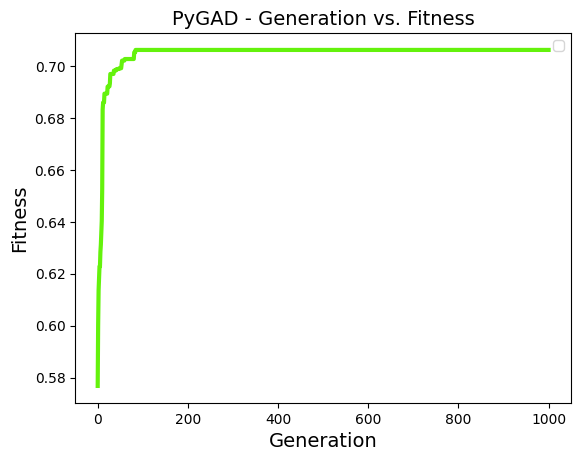

simpleCSMaxDim23*45.yaml : 0
simpleCSMaxDim32x32.yaml : 1
simpleCSMaxDim45*23.yaml : 2
simpleOSMaxDim23*45.yaml : 3
simpleOSMaxDim32x32.yaml : 4
simpleOSMaxDim45*23.yaml : 5


In [67]:
import os
import timeloopfe.v4 as tl
from joblib import Parallel, delayed
from tqdm.auto import tqdm


THIS_SCRIPT_DIR = os.getcwd()
dnnPath = os.path.join(os.getcwd(), "example_designs/layer_shapes/UNet/")
architecturePath = os.path.join(os.getcwd(), "customArchitectures8/")
outputPath = os.path.join(os.getcwd(), "outputs8.UNet/")
componentsPath = os.path.join(os.getcwd(), "components/")
mapperPath = os.path.join(os.getcwd(), "mapper/")
cyclesPerSecond = 100000000
reconfigTime = 0.03 #s
reconfigEnergy = 500000 #uJ
optimizationMetric = "delay"
batchSize = 32

def algorithm(dnnPath, architecturePath, outputPath, componentsPath, mapperPath, cyclesPerSecond, reconfigTime, reconfigEnergy, optimizationMetric, batchSize):
    dnnLayers = (os.listdir(dnnPath))
    if ".ipynb_checkpoints" in dnnLayers:
        dnnLayers.remove(".ipynb_checkpoints")

    architectures = os.listdir(architecturePath)
    if ".ipynb_checkpoints" in architectures:
        architectures.remove(".ipynb_checkpoints")

    unique_combinations = []
 
    for i in range(len(architectures)):
        for j in range(len(dnnLayers)):
            unique_combinations.append((architectures[i], dnnLayers[j]))

    Parallel(n_jobs=8)(
      delayed(runMapper)(architecture, dnnLayer, outputPath, architecturePath, componentsPath, dnnPath, mapperPath) for architecture, dnnLayer in tqdm(unique_combinations)
    )

    print("Timeloop done")

    costs = calculateCosts(cyclesPerSecond, outputPath, optimizationMetric)
    print("costs calculated")
    
    '''
    minimumList = [0]*len(costs[0])
    for i in range(len(costs[0])):
        minimum = 1000000000000
        for j in range(len(costs)):
            if(costs[j][i]) < minimum:
                minimum = costs[j][i]
                minimumList[i] = j

    print("minimumList:", minimumList)
    s = 0
    for i in range(len(costs[0])):
        s = s + costs[minimumList[i]][i]
    print("minimumSum:", s)
    '''
    
    if(optimizationMetric == "delay"):
        findBestPath(batchSize, costs, reconfigTime)
    elif(optimizationMetric == "energy"):
        findBestPath(batchSize, costs, reconfigEnergy)
    elif(optimizationMetric == "edp"):
        findBestPath(batchSize, costs, (reconfigEnergy/1000000)*reconfigTime)  #convert energy from uJ to J

    for i in range(len(architectures)):
        print(architectures[i], ":", i)
    
algorithm(dnnPath, architecturePath, outputPath, componentsPath, mapperPath, cyclesPerSecond, reconfigTime, reconfigEnergy, optimizationMetric, batchSize)
    